In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! ln -s /content/drive/MyDrive/datasets/BreakHis_v1 /content/drive/MyDrive/src/BreakHis_Activation-Map-Generation-Noised-Latent-Factors/datasets

In [2]:
! ln -s /content/drive/MyDrive/src/BreakHis_Activation-Map-Generation-Noised-Latent-Factors/ /content

In [3]:
%cd BreakHis_Activation-Map-Generation-Noised-Latent-Factors/

/content/drive/MyDrive/src/BreakHis_Activation-Map-Generation-Noised-Latent-Factors


In [4]:
! pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

# Initialization

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.15.1


In [6]:
import configs

In [ ]:
import importlib
importlib.reload(configs)
print(dir(configs))

['CGUNET_CHECKPOINT', 'CHECKPOINT_DIR', 'CLASSIFIER_CHECKPOINT', 'CLASS_NAMES', 'DATA_DIR', 'IMAGE_SIZE', 'NUM_CLASS', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


# Data Loader

In [7]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_csv, subset,
                       batch_size=32, shuffle=True):
        self.data_dir = data_dir
        self.subsets_csv = subsets_csv
        self.subset = subset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.load()
        self.indices = None
        self.on_epoch_end()

    def load(self):
        df = pd.read_csv(self.subsets_csv)
        self.filenames = df[df['grp'] == self.subset
                            ]['filename'].tolist()
        self.filenames = [os.path.join(self.data_dir, it)
                          for it in self.filenames]
        print(len(self.filenames), 'images found')
        print(self.filenames[0])

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        X, Y = self.__data_generation(filenames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def filename2onehot(self, fn):
        for i, classname in enumerate(configs.CLASS_NAMES):
            if classname in fn:
                result = np.zeros(configs.NUM_CLASS, dtype=np.float64)
                result[i] = 1
                return result
        return None

    def __data_generation(self, filenames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        for i, fn in enumerate(filenames):
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            delta = (configs.IMAGE_SIZE[1] - configs.IMAGE_SIZE[0]) // 2
            img = img[:, delta:configs.IMAGE_SIZE[1]-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y[i] = self.filename2onehot(fn)

        return X, Y

In [8]:
train_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.DATA_DIR+'/subsets.csv',
                                'train', shuffle=True)
val_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.DATA_DIR+'/subsets.csv',
                                'val', shuffle=False)
test_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.DATA_DIR+'/subsets.csv',
                                'test', shuffle=False)

4000 images found
datasets/BreakHis_v1/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-021.png
1000 images found
datasets/BreakHis_v1/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-003.png
2909 images found
datasets/BreakHis_v1/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-005.png


(32, 256, 256, 3) (32, 8)


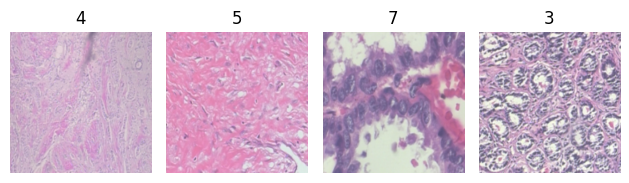

In [ ]:
X, Y = train_datagen[0]
print(X.shape, Y.shape)

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.axis('off')
  plt.title(Y[i].argmax())
plt.tight_layout()
plt.show()

# Classifer 256

In [ ]:
model = tf.keras.models.Sequential(name='classifier256')
model.add(tf.keras.applications.resnet50.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=configs.IMAGE_SIZE)
)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(configs.NUM_CLASS, activation='sigmoid'))
model.add(tf.keras.layers.Softmax())
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "classifier256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
 softmax (Softmax)           (None, 8)                 0         
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Training

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=8,
    verbose=1,
    mode='auto'
)
cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    configs.CHECKPOINT_DIR + '/' + model.name,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    min_lr=0
)
callbacks = [cb_model_checkpoint,
             cb_reduce_lr,
             cb_early_stop]

In [ ]:
history = model.fit_generator(train_datagen,
                    epochs=2024,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_datagen)

<ipython-input-13-d083b1b0c3f0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen,


Epoch 1/2024
125/125 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.6317
Epoch 1: val_loss improved from inf to 2.32836, saving model to checkpoints/classifier256
125/125 [==============================] - 1371s 11s/step - loss: 1.6023 - accuracy: 0.6317 - val_loss: 2.3284 - val_accuracy: 0.0590 - lr: 1.0000e-04
Epoch 2/2024
125/125 [==============================] - ETA: 0s - loss: 1.3984 - accuracy: 0.8405
Epoch 2: val_loss improved from 2.32836 to 2.25523, saving model to checkpoints/classifier256
125/125 [==============================] - 98s 782ms/step - loss: 1.3984 - accuracy: 0.8405 - val_loss: 2.2552 - val_accuracy: 0.0590 - lr: 1.0000e-04
Epoch 3/2024
125/125 [==============================] - ETA: 0s - loss: 1.3566 - accuracy: 0.8947
Epoch 3: val_loss improved from 2.25523 to 2.00629, saving model to checkpoints/classifier256
125/125 [==============================] - 104s 832ms/step - loss: 1.3566 - accuracy: 0.8947 - val_loss: 2.0063 - val_accuracy

In [ ]:
pd.DataFrame.from_dict(history.history) \
           .to_csv(configs.CHECKPOINT_DIR+'/'+
                   model.name +
                   '/history_classifier256.csv', index=False)

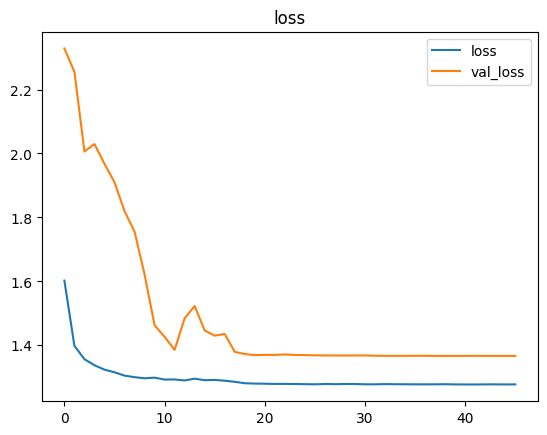

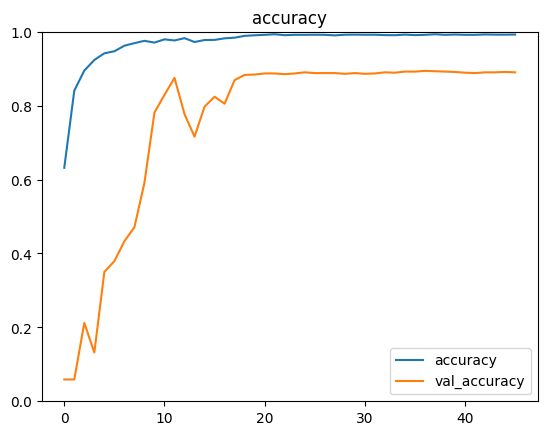

In [ ]:
df = pd.read_csv(configs.CLASSIFIER_CHECKPOINT +
                 '/history_classifier256.csv')

plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend()
plt.title('loss')
# plt.ylim(0, 3)
plt.show()

plt.plot(df['accuracy'], label='accuracy')
plt.plot(df['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('accuracy')
plt.ylim(0, 1)
plt.show()

# Evaluation

In [9]:
model = tf.keras.models.load_model(configs.CLASSIFIER_CHECKPOINT)
train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)
val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)
test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)
print(train_loss, val_loss, test_loss)
print(train_acc, val_acc, test_acc)

<ipython-input-9-bda72bdbc285>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)


125/125 [==============================] - 1182s 9s/step - loss: 1.2769 - accuracy: 0.9923


<ipython-input-9-bda72bdbc285>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)


32/32 [==============================] - 285s 9s/step - loss: 1.3667 - accuracy: 0.8930


<ipython-input-9-bda72bdbc285>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)


91/91 [==============================] - 850s 9s/step - loss: 1.3603 - accuracy: 0.8993
1.2768806219100952 1.366724967956543 1.360324740409851
0.9922500252723694 0.8930000066757202 0.8992781043052673


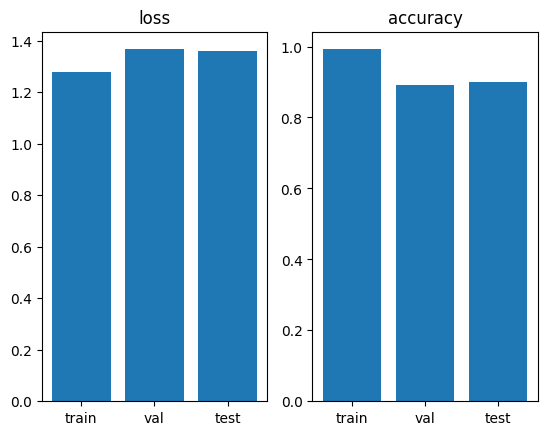

In [10]:
plt.subplot(1, 2, 1)
plt.bar(['train', 'val', 'test'], [1.2769, 1.3667, 1.3603])
plt.title('loss')
plt.subplot(1, 2, 2)
plt.bar(['train', 'val', 'test'], [0.9923, 0.8930, 0.8993])
plt.title('accuracy')
plt.show()